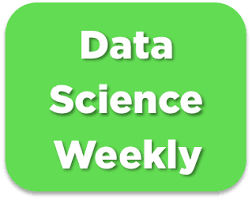

# Challenge : predict conversions 🏆🏆
In this project, you will participate to a machine learning competition like the ones that are organized by https://www.kaggle.com/. You will be able to work with jupyter notebooks as usual, but in the end you'll have to submit your model's predictions to your teacher/TA, so your model's performances will be evaluated in an independent way. The scores achieved by the different teams will be stored into a leaderboard 🏅🏅

## Description of a machine learning challenge 🚴🚴
- In machine learning challenges, the dataset is always separated into to files :
    - *data_train.csv* contains **labelled data**, which means there are both X (explanatory variables) and Y (the target to be predicted). You will use this file to train your model as usual : make the train/test split, preprocessings, assess performances, try different models, fine-tune hyperparameters etc...
    - *data_test.csv* contains "new" examples that have not be used to train the model, in the same format as in *data_train.csv* but it is **unlabeled**, which means the target Y has been removed from the file. Once you've trained a model, you will use *data_test.csv* to make some predictions that you will send to the organizing team. They will then be able to assess the performances of your model in an independent way, by preventing cheating 🤸
- Your model's predictions will be compared to the true labels and releases a leaderboard where the scores of all the teams around the world are stored
- All the participants are informed about the metric that will be used to assess the scores. You have to make sure you're using the same metric to evaluate your train/test performances !

## Company's Description 📇
www.datascienceweekly.org is a famous newsletter curated by independent data scientists. Anyone can register his/her e-mail address on this website to receive weekly news about data science and its applications !

## Project 🚧
The data scientists who created the newsletter would like to understand better the behaviour of the users visiting their website. They would like to know if it's possible to build a model that predicts if a given user will subscribe to the newsletter, by using just a few information about the user. They would like to analyze the parameters of the model to highlight features that are important to explain the behaviour of the users, and maybe discover a new lever for action to improve the newsletter's conversion rate.

They designed a competition aiming at building a model that allows to predict the *conversions* (i.e. when a user will subscribe to the newsletter). To do so, they open-sourced a dataset containing some data about the traffic on their website. To assess the rankings of the different competing teams, they decided to use the **f1-score**.

## Goals 🎯
The project can be cut into four steps :
- Part 1 : make an EDA and the preprocessings and train a baseline model with the file *data_train.csv*
- Part 2 : improve your model's f1-score on your test set (you can try feature engineering, feature selection, regularization, non-linear models, hyperparameter optimization by grid search, etc...)
- Part 3 : Once you're satisfied with your model's score, you can use it to make some predictions with the file *data_test.csv*. You will have to dump the predictions into a .csv file that will be sent to Kaggle (actually, to your teacher/TA 🤓). You can make as many submissions as you want, feel free to try different models !
- Part 4 : Take some time to analyze your best model's parameters. Are there any lever for action that would help to improve the newsletter's conversion rate ? What recommendations would you make to the team ?

## Deliverable 📬
To complete this project, your team should: 
- Create some relevant figures for EDA
- Train at least one model that predicts the conversions and evaluate its performances (f1, confusion matrices)
- Make at least one submission to the leaderboard 
- Analyze your best model's parameters and try to make some recommendations to improve the conversion rate in the future

# Preparation of the datasets

In [28]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SequentialFeatureSelector

from imblearn.over_sampling import SMOTENC
from collections import Counter

import matplotlib.pyplot as plt
import plotly.express as px

## Dataset 

In [3]:
# see Notebook "EDA" for the reasoning behind these choices

data = pd.read_csv('conversion_data_train.csv')
data = data.loc[data['age']<80,:]
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


## Creation of train and test sets

In [5]:
features_list = list(data.columns)
features_list.remove('converted')
target_variable = 'converted'

X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, stratify = Y, random_state=0)

X_train['country'].astype("category")
X_train['new_user'].astype("category")
X_train['source'].astype("category")
X_test['country'].astype("category")
X_test['new_user'].astype("category")
X_test['source'].astype("category")

print("...Done.")

Dividing into train and test sets...
...Done.


## Preprocessing

In [6]:
print("Encoding categorical features and standardizing numerical features...")

numeric_features = features_list
numeric_features.remove("country")
numeric_features.remove("new_user")
numeric_features.remove("source")
categorical_features = ["country", "new_user", "source"]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop="first")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

print("...Done")

Encoding categorical features and standardizing numerical features...
...Done


# Models 

## Without feature engineering

### Baseline

In [14]:
# Simple Logistic Regression

baseline = LogisticRegression()
baseline.fit(X_train, Y_train)
Y_train_pred = baseline.predict(X_train)
Y_test_pred = baseline.predict(X_test)
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7625754527162979
f1-score on test set :  0.7711711711711712


### Other models with grid search

In [19]:
# Logistic Regression with class weights and L2

logreg = LogisticRegressionCV(penalty='l2') 
params = {
    'Cs': [5, 10, 15], 
    'class_weight': [
        None,
        {0: 1, 1: 1.3},
        {0: 1, 1: 1.5},
        'balanced'
    ]
}
gridsearch = GridSearchCV(logreg, scoring="precision", param_grid = params, cv = 3, verbose = 2)
gridsearch.fit(X_train, Y_train)

print("Best Parameters:", gridsearch.best_params_)
print("Best Score:", gridsearch.best_score_)

Y_train_pred = gridsearch.predict(X_train)
Y_test_pred = gridsearch.predict(X_test)

print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[CV] END ............................Cs=5, class_weight=None; total time=   2.6s
[CV] END ............................Cs=5, class_weight=None; total time=   2.6s
[CV] END ............................Cs=5, class_weight=None; total time=   2.7s
[CV] END ..................Cs=5, class_weight={0: 1, 1: 1.3}; total time=   2.7s
[CV] END ..................Cs=5, class_weight={0: 1, 1: 1.3}; total time=   2.7s
[CV] END ..................Cs=5, class_weight={0: 1, 1: 1.3}; total time=   2.7s
[CV] END ..................Cs=5, class_weight={0: 1, 1: 1.5}; total time=   2.7s
[CV] END ..................Cs=5, class_weight={0: 1, 1: 1.5}; total time=   2.9s
[CV] END ..................Cs=5, class_weight={0: 1, 1: 1.5}; total time=   2.9s
[CV] END ........................Cs=5, class_weight=balanced; total time=   2.8s
[CV] END ........................Cs=5, class_weight=balanced; total time=   3.0s
[CV] END ........................Cs=5, class_weight=balanced; total time=   3.1s
[CV] END ...................

In [23]:
# Random forest with class weights

RFC = RandomForestClassifier()
params = {
    'max_depth': [10, 20],
    'min_samples_leaf': [10, 20, 30],
    'min_samples_split': [10, 20, 30],
    'n_estimators': [40, 50],
    'class_weight': [
        None,
        {0: 1, 1: 1.3},
        {0: 1, 1: 1.5}
    ]
}
gridsearch = GridSearchCV(RFC, param_grid = params, scoring='precision', cv = 3, verbose = 2)
gridsearch.fit(X_train, Y_train)

print("Best Parameters:", gridsearch.best_params_)
print("Best Score:", gridsearch.best_score_)

Y_train_pred = gridsearch.predict(X_train)
Y_test_pred = gridsearch.predict(X_test)

print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[CV] END class_weight=None, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=40; total time=   2.7s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=40; total time=   2.6s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=40; total time=   2.6s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   3.4s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   3.3s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   3.3s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=10, min_samples_split=20, n_estimators=40; total time=   2.7s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=10, min_samples_split=20, n_estimators=40; total time=   2.7s
[CV] END class_weight=None, max_

In [21]:
# XGBoost with class weights

XGBC = XGBClassifier()
weight_ratio = float(len(Y_train[Y_train == 0]))/float(len(Y_train[Y_train == 1]))
params = {
    "max_depth": [2, 4, 6, 8],
    "min_child_weight": [2, 4, 6, 8, 10],
    "n_estimators": [10, 25, 50],
    'scale_pos_weight': [weight_ratio, 1]
}
gridsearch = GridSearchCV(XGBC, param_grid = params, scoring='precision', cv = 3, verbose = 2)
gridsearch.fit(X_train, Y_train)

print("Best Parameters:", gridsearch.best_params_)
print("Best Score:", gridsearch.best_score_)

Y_train_pred = gridsearch.predict(X_train)
Y_test_pred = gridsearch.predict(X_test)

print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

Fitting 3 folds for each of 120 candidates, totalling 360 fits
[CV] END max_depth=2, min_child_weight=2, n_estimators=10, scale_pos_weight=30.00726392251816; total time=   0.7s
[CV] END max_depth=2, min_child_weight=2, n_estimators=10, scale_pos_weight=30.00726392251816; total time=   0.2s
[CV] END max_depth=2, min_child_weight=2, n_estimators=10, scale_pos_weight=30.00726392251816; total time=   0.2s


[CV] END max_depth=2, min_child_weight=2, n_estimators=10, scale_pos_weight=1; total time=   0.3s
[CV] END max_depth=2, min_child_weight=2, n_estimators=10, scale_pos_weight=1; total time=   0.5s
[CV] END max_depth=2, min_child_weight=2, n_estimators=10, scale_pos_weight=1; total time=   0.2s
[CV] END max_depth=2, min_child_weight=2, n_estimators=25, scale_pos_weight=30.00726392251816; total time=   0.7s
[CV] END max_depth=2, min_child_weight=2, n_estimators=25, scale_pos_weight=30.00726392251816; total time=   0.3s
[CV] END max_depth=2, min_child_weight=2, n_estimators=25, scale_pos_weight=30.00726392251816; total time=   0.3s
[CV] END max_depth=2, min_child_weight=2, n_estimators=25, scale_pos_weight=1; total time=   0.3s
[CV] END max_depth=2, min_child_weight=2, n_estimators=25, scale_pos_weight=1; total time=   0.3s
[CV] END max_depth=2, min_child_weight=2, n_estimators=25, scale_pos_weight=1; total time=   0.4s
[CV] END max_depth=2, min_child_weight=2, n_estimators=50, scale_pos_w

### Voting on the best models

In [24]:
voting = VotingClassifier(
    estimators=[("logistic", LogisticRegressionCV(Cs=10, penalty='l2')), 
                 ("tree", RandomForestClassifier(max_depth=10, min_samples_leaf=10, 
                    min_samples_split=20, n_estimators=50)), 
                 ("XGboosting", XGBClassifier(max_depth=2, min_child_weight=8, n_estimators=25))],
    voting="soft",
)
voting.fit(X_train, Y_train, )

Y_train_pred = voting.predict(X_train)
Y_test_pred = voting.predict(X_test)

print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7634372253397335
f1-score on test set :  0.7579963789981895


## Best model with feature engineering

In [25]:
data_feateng = data.copy()

data_feateng['Age/Pages'] = data_feateng['age'] / data_feateng['total_pages_visited']
data_feateng['AgexNew'] = data_feateng['age'] * data_feateng['new_user'].replace({0:0.5, 1:1})

data_feateng["log_total_pages_visited"] = np.log(data_feateng["total_pages_visited"])   
data_feateng["sqrt_total_pages_visited"] = np.sqrt(data_feateng["total_pages_visited"])   
data_feateng["sq_total_pages_visited"] = data_feateng["total_pages_visited"] ** 2
data_feateng["sq3_total_pages_visited"] = data_feateng["total_pages_visited"] ** 3
data_feateng["sq4_total_pages_visited"] = data_feateng["total_pages_visited"] ** 4
data_feateng["inv_total_pages_visited"] = 1 / data_feateng["total_pages_visited"]

data_feateng["log_age"] = np.log(data_feateng["age"])   
data_feateng["sqrt_age"] = np.sqrt(data_feateng["age"])   
data_feateng["sq_age"] = data_feateng["age"] ** 2
data_feateng["sq3_age"] = data_feateng["age"] ** 3
data_feateng["sq4_age"] = data_feateng["age"] ** 4
data_feateng["inv_age"] = 1 / data_feateng["age"]

data_feateng.head()

,country,age,new_user,source,total_pages_visited,converted,Age/Pages,AgexNew,log_total_pages_visited,sqrt_total_pages_visited,sq_total_pages_visited,sq3_total_pages_visited,sq4_total_pages_visited,inv_total_pages_visited,log_age,sqrt_age,sq_age,sq3_age,sq4_age,inv_age
0,China,22,1,Direct,2,0,11.000000,22.0,0.693147,1.414214,4,8,16,0.500000,3.091042,4.690416,484,10648,234256,0.045455
1,UK,21,1,Ads,3,0,7.000000,21.0,1.098612,1.732051,9,27,81,0.333333,3.044522,4.582576,441,9261,194481,0.047619
2,Germany,20,0,Seo,14,1,1.428571,10.0,2.639057,3.741657,196,2744,38416,0.071429,2.995732,4.472136,400,8000,160000,0.050000
3,US,23,1,Seo,3,0,7.666667,23.0,1.098612,1.732051,9,27,81,0.333333,3.135494,4.795832,529,12167,279841,0.043478
4,US,28,1,Direct,3,0,9.333333,28.0,1.098612,1.732051,9,27,81,0.333333,3.332205,5.291503,784,21952,614656,0.035714


In [26]:
features_list_feateng = list(data_feateng.columns)
features_list_feateng.remove('converted')
X_feateng = data_feateng.loc[:, features_list_feateng]
Y_feateng = data_feateng.loc[:, target_variable]
X_train_feateng, X_test_feateng, Y_train_feateng, Y_test_feateng = train_test_split(X_feateng, Y_feateng, test_size=0.1, 
                                                                                    stratify = Y_feateng, random_state=0)
X_train_feateng['country'].astype("category")
X_train_feateng['new_user'].astype("category")
X_train_feateng['source'].astype("category")
X_test_feateng['country'].astype("category")
X_test_feateng['new_user'].astype("category")
X_test_feateng['source'].astype("category")

numeric_features_feateng = features_list_feateng
numeric_features_feateng.remove("country")
numeric_features_feateng.remove("new_user")
numeric_features_feateng.remove("source")
preprocessor_feateng = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features_feateng),
        ("cat", categorical_transformer, categorical_features),
    ]
)
X_train_feateng = preprocessor_feateng.fit_transform(X_train_feateng)
X_test_feateng = preprocessor_feateng.transform(X_test_feateng)

In [33]:
classifier = LogisticRegression()
feature_selector =  SequentialFeatureSelector(classifier, n_features_to_select = 10) 
feature_selector.fit(X_train_feateng, Y_train)

column_names = []
for name, step, features_list in preprocessor_feateng.transformers_: 
    if name == 'num': 
        features = features_list 
    else: 
        features = step.get_feature_names_out() 
    column_names.extend(features) 

print("According to the forward selection algorithm, the following features should be kept: ")
for i in range(len(feature_selector.support_)):
    if feature_selector.support_[i] == True:
        print(column_names[i])

According to the forward selection algorithm, the following features should be kept: 
total_pages_visited
Age/Pages
AgexNew
sqrt_total_pages_visited
sq_age
country_Germany
country_UK
country_US
new_user_1
source_Seo


In [34]:
data_feateng = data.copy()

data_feateng['Age/Pages'] = data_feateng['age'] / data_feateng['total_pages_visited']
data_feateng['AgexNew'] = data_feateng['age'] * data_feateng['new_user'].replace({0:0.5, 1:1})
data_feateng["sqrt_total_pages_visited"] = np.sqrt(data_feateng["total_pages_visited"])    
data_feateng["sq_age"] = data_feateng["age"] ** 2

features_list_feateng = list(data_feateng.columns)
features_list_feateng.remove('converted')
X_feateng = data_feateng.loc[:, features_list_feateng]
Y_feateng = data_feateng.loc[:, target_variable]
X_train_feateng, X_test_feateng, Y_train_feateng, Y_test_feateng = train_test_split(X_feateng, Y_feateng, test_size=0.1, 
                                                                                    stratify = Y_feateng, random_state=0)
X_train_feateng['country'].astype("category")
X_train_feateng['new_user'].astype("category")
X_train_feateng['source'].astype("category")
X_test_feateng['country'].astype("category")
X_test_feateng['new_user'].astype("category")
X_test_feateng['source'].astype("category")

numeric_features_feateng = features_list_feateng
numeric_features_feateng.remove("country")
numeric_features_feateng.remove("new_user")
numeric_features_feateng.remove("source")
preprocessor_feateng = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features_feateng),
        ("cat", categorical_transformer, categorical_features),
    ]
)
X_train_feateng = preprocessor_feateng.fit_transform(X_train_feateng)
X_test_feateng = preprocessor_feateng.transform(X_test_feateng)

In [40]:
params = {
    'Cs': [5, 10, 15], 
    'class_weight': [
        None,
        {0: 1, 1: 1.3},
        {0: 1, 1: 1.5},
        'balanced'
    ]
}
gridsearch = GridSearchCV(logreg, param_grid = params, scoring='precision', cv = 3, verbose = 2)
gridsearch.fit(X_train_feateng, Y_train)

print("Best Parameters:", gridsearch.best_params_)
print("Best Score:", gridsearch.best_score_)

Y_train_pred = gridsearch.predict(X_train_feateng)
Y_test_pred = gridsearch.predict(X_test_feateng)

print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ............................Cs=5, class_weight=None; total time=   6.6s
[CV] END ............................Cs=5, class_weight=None; total time=   6.6s
[CV] END ............................Cs=5, class_weight=None; total time=   6.8s
[CV] END ..................Cs=5, class_weight={0: 1, 1: 1.3}; total time=   7.0s
[CV] END ..................Cs=5, class_weight={0: 1, 1: 1.3}; total time=   6.7s
[CV] END ..................Cs=5, class_weight={0: 1, 1: 1.3}; total time=   7.1s
[CV] END ..................Cs=5, class_weight={0: 1, 1: 1.5}; total time=   6.7s
[CV] END ..................Cs=5, class_weight={0: 1, 1: 1.5}; total time=   7.1s
[CV] END ..................Cs=5, class_weight={0: 1, 1: 1.5}; total time=   6.3s
[CV] END ........................Cs=5, class_weight=balanced; total time=   7.2s
[CV] END ........................Cs=5, class_weight=balanced; total time=   6.9s
[CV] END ........................Cs=5, class_wei

Conclusion : les feature engineering ne semblent pas améliorer le modèle

## Using SMOTE to compensate for imbalanced data

In [42]:
print(X_train[0:5])

[[-1.51987065 -0.26099836  0.          0.          1.          0.
   0.          1.        ]
 [ 2.2307148   0.03829244  0.          0.          0.          0.
   0.          1.        ]
 [ 1.86775492 -0.56028917  0.          0.          0.          1.
   0.          1.        ]
 [-1.51987065 -1.15887077  0.          0.          1.          0.
   0.          0.        ]
 [-1.03592414  0.33758325  0.          0.          1.          1.
   0.          0.        ]]


In [43]:
sm = SMOTENC(categorical_features=[2,3,4,5,6,7], sampling_strategy=0.05)

X_train_resampled, Y_train_resampled = sm.fit_resample(X_train, Y_train)

print('Original dataset shape:', Counter(Y_train))
print('Resampled dataset shape:', Counter(Y_train_resampled))

xgbc_smote = XGBClassifier()
params = {
    "max_depth": [2, 4, 6, 8, 10],
    "min_child_weight": [2, 4, 6, 8, 10],
    "n_estimators": [10, 25, 50, 75, 100]
}
gridsearch = GridSearchCV(xgbc_smote, param_grid = params, scoring='f1', cv = 3, verbose = 2)
gridsearch.fit(X_train_resampled, Y_train_resampled, eval_set = [(X_test, Y_test)])

print("Best Parameters:", gridsearch.best_params_)
print("Best Score:", gridsearch.best_score_)

Y_train_pred = gridsearch.predict(X_train)
Y_test_pred = gridsearch.predict(X_test)

print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

Original dataset shape: Counter({0: 247860, 1: 8260})
Resampled dataset shape: Counter({0: 247860, 1: 12393})
Fitting 3 folds for each of 125 candidates, totalling 375 fits
[0]	validation_0-logloss:0.14946
[1]	validation_0-logloss:0.11965
[2]	validation_0-logloss:0.09953
[3]	validation_0-logloss:0.08542
[4]	validation_0-logloss:0.07557
[5]	validation_0-logloss:0.06807
[6]	validation_0-logloss:0.06257
[7]	validation_0-logloss:0.05866
[8]	validation_0-logloss:0.05577
[9]	validation_0-logloss:0.05362
[CV] END ...max_depth=2, min_child_weight=2, n_estimators=10; total time=   0.6s
[0]	validation_0-logloss:0.14956
[1]	validation_0-logloss:0.11977
[2]	validation_0-logloss:0.09967
[3]	validation_0-logloss:0.08562
[4]	validation_0-logloss:0.07573
[5]	validation_0-logloss:0.06834
[6]	validation_0-logloss:0.06297
[7]	validation_0-logloss:0.05897
[8]	validation_0-logloss:0.05586
[9]	validation_0-logloss:0.05380
[CV] END ...max_depth=2, min_child_weight=2, n_estimators=10; total time=   0.5s
[0]	v

# Submission to the leaderboard of the best model

In [ ]:
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

logreg = LogisticRegressionCV(Cs=10, class_weight={0: 1, 1: 1.5}).fit(X,Y)
RFC = RandomForestClassifier(class_weight={0: 1, 1: 1.3}, max_depth=40, min_samples_leaf=15, 
                            min_samples_split=100, n_estimators=70).fit(X,Y)
XGBC = XGBClassifier(max_depth=4, min_child_weight=2, n_estimators=25).fit(X,Y)
voting.fit(X,Y)
X_resampled, Y_resampled = sm.fit_resample(X, Y)
xgbc_smote = XGBClassifier(max_depth=8, min_child_weight=4, n_estimators=50).fit(X_resampled, Y_resampled)

# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels):', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same as the features 
# used by your best classifier)
#features_list = ['total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to arrays before using scikit-learn
print("Convert pandas DataFrames to arrays...")
#X_without_labels = X_without_labels.values
print("...Done")

#print(X_without_labels[0:5,:])
print(X_without_labels.head())

# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = preprocessor.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': voting.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_EUGENIE-model14.csv', index=False)


# Conclusions

In [ ]:
# confusion matrixes for the best model

_, ax = plt.subplots()
ax.set(
    title="Confusion Matrix on Train set"
)  
ConfusionMatrixDisplay.from_estimator(
    #classifier, 
    X_train, Y_train, ax=ax
) 
plt.show()

_, ax = plt.subplots() 
ax.set(
    title="Confusion Matrix on Test set"
)  
ConfusionMatrixDisplay.from_estimator(
    #classifier, 
    X_test, Y_test, ax=ax
)  
plt.show()

In [ ]:
# autres scores, tels que dans le classification_report qu'on utilisait en DL

In [ ]:
# AUC ?

In [ ]:
# Analysing the best model's parameters

column_names = []
for name, pipeline, features_list in preprocessor.transformers_: 
    if name == 'num': 
        features = features_list 
    else: 
        features = pipeline.named_steps['encoder'].get_feature_names_out() 
    column_names.extend(features) 
        
coefs = pd.DataFrame(index = column_names, data = classifier.coef_.transpose(), columns=["coefficients"])
coefs
feature_importance = abs(coefs).sort_values(by = 'coefficients')

fig = px.bar(feature_importance, orientation = 'h')
fig.update_layout(showlegend = False, 
                  margin = {'l': 120} 
                 )
fig.show()

Perpectives : 
- tester les modèles en appliquant un threshold pour le choix de la labellisation, qui ne soit pas 0.5 (valeur par défaut)